# State Student Spending Case Study
#### Examining any relationship between student sucess or lack thereof with how much money the state has invested.
Using each state's dropout rate as a benchmark of student success. We will investigate any correlations.


### Necessary Steps for Data Story
##### 1) Clean the Data 
    a. Import Data
    b. Transform variables
##### 2) Merge the Data
##### 3) Exploratory Data Analysis
    a. Visualize the data
##### 4) Preprocess and Train Data
##### 5) Create Machine Learning Model
##### 6) Summarize Findings

In [1]:
#import necessary modules

import pandas as pd
import numpy as np
import seaborn as sns
from plotnine import *

# 1. Import Data

In [2]:
#import Graduation rate, Dropout rate, State Spending, Population, & State GDP data
Grad = pd.read_csv('Data/Completion1318edit.csv')
Drop = pd.read_csv('Data/Dropout1318edit.csv')
StateSpend = pd.read_excel('Data/StateSpendingStudents.xlsx')
Pop = pd.read_csv('Data/Pop10-19.csv')
GDP = pd.read_csv('Data/State Quarterly GDP 2005 - 2021 - Sheet1.csv')

In [3]:
#import tax data 
Tax13 = pd.read_csv('Data/2013 State Taxes.csv').replace('X', 0)
Tax14 = pd.read_csv('Data/2014 State Taxes.csv').replace('X', 0)
Tax15 = pd.read_csv('Data/2015 State Taxes.csv').replace('X', 0)
Tax16 = pd.read_csv('Data/2016 State Taxes.csv').replace('X', 0)
Tax17 = pd.read_csv('Data/2017 State Taxes.csv').replace('X', 0)
Tax18 = pd.read_csv('Data/2018 State Taxes.csv').replace('X', 0)
Tax19 = pd.read_csv('Data/2019 State Taxes.csv').replace('X', 0)


#Note to self to automate process:
#Try a dictionary. Start with empty dictionary. Wild cards to read itieratively * .csv

## Cleaning Tax Data

In [4]:
#Examing the column names: Need to change them to match the rest of the data
#Tax13.columns

In [5]:
#Dictionary to change state abbreviations to full state names
us_state_abbrev = {
    'AL': 'Alabama',
    'AK': 'Alaska',
    'AZ': 'Arizona',
    'AR': 'Arkansas',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'IA': 'Iowa',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'ME': 'Maine',
    'MD': 'Maryland',
    'MA': 'Massachusetts',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MS': 'Mississippi',
    'MO': 'Missouri',
    'MT': 'Montana',
    'NE': 'Nebraska',
    'NV': 'Nevada',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NY': 'New York',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VT': 'Vermont',
    'VA': 'Virginia',
    'WA': 'Washington',
    'WV': 'West Virginia',
    'WI': 'Wisconsin',
    'WY': 'Wyoming',
    'District of Columbia': 'DC',
}

In [6]:
#Load all the individual tax files into one frame with an appropriate year varibable

TaxList = [Tax13, Tax14, Tax15, Tax16, Tax17, Tax18, Tax19]

TaxFile = pd.DataFrame()


initial_year = 2013
for loc_file in TaxList:
  loc_file = loc_file.iloc[:,1:]
  loc_file['Year'] = str(initial_year)
  loc_file = loc_file.melt(id_vars='Year', value_name = 'tax_all', var_name='State')
  TaxFile  = TaxFile.append(loc_file)
  initial_year = initial_year + 1

In [7]:
#Sum all the different types of tax categories
TaxFile['tax_all'] = TaxFile['tax_all'].astype('float')

AllTaxes = TaxFile.groupby(['State', 'Year'])['tax_all'].sum().reset_index()
AllTaxes.head()


,State,Year,tax_all
0,AK,2013,5132811.0
1,AK,2014,3392870.0
2,AK,2015,1363350.0
3,AK,2016,896921.0
4,AK,2017,1208929.0


In [8]:
#Fix the naming
AllTaxes['State'] = AllTaxes['State'].replace(us_state_abbrev)
AllTaxes.head()

,State,Year,tax_all
0,Alaska,2013,5132811.0
1,Alaska,2014,3392870.0
2,Alaska,2015,1363350.0
3,Alaska,2016,896921.0
4,Alaska,2017,1208929.0


## Cleaning Median Income Data

In [9]:
#Read in Median Income 
#(Deleted out Standard Deviation as well as repetitive information from original file)
MedianInc = pd.read_csv('Data/Median Income Edit.csv')

#Flip
MedianInc = MedianInc.melt(id_vars = 'State', var_name='Year', value_name = 'MedInc')

MedianInc.head()

,State,Year,MedInc
0,United States,2018,"63,179"
1,Alabama,2018,"49,936"
2,Alaska,2018,"68,734"
3,Arizona,2018,"62,283"
4,Arkansas,2018,"49,781"


In [10]:
#Remove commas from integers so we can explore numerical calculations

for x in range(len(MedianInc)):
    MedianInc['MedInc'][x] = MedianInc['MedInc'][x].replace(',' , '')

In [11]:
MedianInc.tail()

,State,Year,MedInc
1815,Virginia,1984,26525
1816,Washington,1984,25017
1817,West Virginia,1984,16843
1818,Wisconsin,1984,20743
1819,Wyoming,1984,23816


## Cleaning Graduation and Drop Out Data

In [12]:
#Examine data
print(Grad.columns)

Index(['State', '2012-2013', '2013-2014', '2014-2015', '2015-2016',
       '2016-2017', '2017-2018'],
      dtype='object')


In [13]:
#Rename columns so they match years in other files.
oldname = Grad.columns
newname = ['State', 2013, 2014, 2015, 2016, 2017, 2018 ]
Grad = Grad.rename(columns=dict(zip(oldname, newname)))

#Flip so States are columns
Grad = Grad.melt(id_vars = ['State'], var_name='Year', value_name = 'Graduates')


#Examine
Grad.head()

,State,Year,Graduates
0,United States,2013,81.4
1,Alabama,2013,80.0
2,Alaska,2013,71.8
3,Arizona,2013,75.1
4,Arkansas,2013,84.9


In [14]:
#Examine data
print(Drop.head())
print(Drop.columns)

           State  2013  2014  2015  2016  2017  2018
0  United States   6.8   6.3   6.0   5.8   5.4   5.3
1        Alabama   8.9   7.7   7.4   6.9   6.6   5.4
2         Alaska   6.2   2.8   8.8   5.6   5.3   4.4
3        Arizona   9.4   8.5   9.2   7.6   8.0   7.7
4       Arkansas   6.8   6.8   6.7   7.2   5.7   5.6
Index(['State', '2013', '2014', '2015', '2016', '2017', '2018'], dtype='object')


In [15]:
#Flip so States are columns
Drop = Drop.melt(id_vars = ['State'], var_name='Year', value_name = 'Dropout')

#Examine
Drop.head()

,State,Year,Dropout
0,United States,2013,6.8
1,Alabama,2013,8.9
2,Alaska,2013,6.2
3,Arizona,2013,9.4
4,Arkansas,2013,6.8


## Clean State Spending Data

In [16]:
#StateSpend.head() to examine data before cleaning

In [17]:
#Realign with States as columns & make sure the column names match the other data files.
StateSpend.rename(columns = {'state': 'State'}, inplace = True)
StateSpend = StateSpend.melt(id_vars = ['State'], var_name='Year', value_name = 'StateSpend')
StateSpend.head()

#Examine
print(StateSpend.head())

        State  Year  StateSpend
0     Alabama  1997   3271969.0
1      Alaska  1997   1042311.0
2     Arizona  1997   3388165.0
3    Arkansas  1997   1960613.0
4  California  1997  28708364.0


## Clean Population Data

In [18]:
#Examine the Population
# print(Pop.head())

In [19]:
#Fix geographic area names & delete unnecessary strings

Pop = Pop.drop(columns = ['Census', 'Estimates Base']).iloc[:58,]
Pop['Geographic Area'] = Pop['Geographic Area'].str.replace('.','')


# Combine and examine
Pop = Pop.melt(id_vars = 'Geographic Area',var_name='Year',value_name = 'Population')
Pop.tail()

,Geographic Area,Year,Population
555,Virginia,2019,"8,535,519"
556,Washington,2019,"7,614,893"
557,West Virginia,2019,"1,792,147"
558,Wisconsin,2019,"5,822,434"
559,Wyoming,2019,"578,759"


In [20]:
#Change column name to match other datasets
Pop = Pop.rename(columns={'Geographic Area' : 'State'})
Pop.head()

,State,Year,Population
0,United States,2010,"309,321,666"
1,Northeast,2010,"55,380,134"
2,Midwest,2010,"66,974,416"
3,South,2010,"114,866,680"
4,West,2010,"72,100,436"


In [21]:
Pop['Population'] = Pop['Population'].replace(" ' '", '')
Pop.head()

,State,Year,Population
0,United States,2010,"309,321,666"
1,Northeast,2010,"55,380,134"
2,Midwest,2010,"66,974,416"
3,South,2010,"114,866,680"
4,West,2010,"72,100,436"


In [22]:
#Remove commas from integers for ease of numerical computations
for x in range(len(Pop)):
    Pop['Population'][x] = Pop['Population'][x].replace(',' , '')

In [23]:
Pop.head()

,State,Year,Population
0,United States,2010,309321666
1,Northeast,2010,55380134
2,Midwest,2010,66974416
3,South,2010,114866680
4,West,2010,72100436


## Clean GDP  Data

In [24]:
#Examine GDP data before edits
# GDP.head()

In [25]:
# In order to average the GDP by year we need to extract the year
GDP['Year'] = GDP['DATE'].str[:4]
GDP.drop(columns = 'DATE', inplace = True)
GDP.head()

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,Year
0,153077.8,37393.9,219879.5,87648.2,1071327.2,215960.0,205563.8,50938.8,84367.6,679535.2,...,224177.7,959728.9,90791.3,23305.0,351558.7,289799.4,51590.1,222355.1,25403.1,2005
1,155409.9,38641.2,225374.3,88484.4,1147944.3,218742.0,207535.4,49992.1,85216.8,688958.5,...,225712.9,966652.1,92408.8,23288.1,358082.4,294263.7,52859.3,224122.0,26571.8,2005
2,156809.7,40259.9,232290.1,89890.7,1247734.4,222965.7,208749.0,50351.7,85499.3,708198.9,...,229952.8,993026.3,95362.0,23560.3,365491.2,295654.5,53610.3,228348.1,27453.0,2005
3,160315.8,42859.7,235386.5,92549.3,1366166.5,223561.9,212795.6,56830.1,86313.2,712347.7,...,232661.9,1025403.5,98650.0,23850.2,368236.9,303717.2,55111.1,227537.6,29448.8,2005
4,161732.8,42664.7,242418.5,92836.0,1387551.8,228594.0,221184.4,54220.3,87757.7,732154.4,...,236210.0,1054437.0,102069.5,24289.8,375995.3,310466.5,55639.7,232585.7,30455.1,2006


In [26]:
#Melt it down 
GDP = GDP.melt(id_vars = ['Year'], var_name='State', value_name = 'GDP')
GDP.head()

,Year,State,GDP
0,2005,Alabama,153077.8
1,2005,Alabama,155409.9
2,2005,Alabama,156809.7
3,2005,Alabama,160315.8
4,2006,Alabama,161732.8


In [27]:
#Find the average yearly GDP
YearlyGDP = GDP.groupby(['State', 'Year'])['GDP'].mean().reset_index()

In [28]:
YearlyGDP.head()

,State,Year,GDP
0,Alabama,2005,156403.30
1,Alabama,2006,164347.85
2,Alabama,2007,170263.85
3,Alabama,2008,172677.25
4,Alabama,2009,169128.50


## Clean Unemployment Rates

In [29]:
# Empty data frame
Unemployment = pd.DataFrame()


for i in np.arange(2009,2018,1):
    print("Reading: {}".format(str(i)))
    
    year_data = pd.read_excel('Data/UnemploymentRateData_Parsed.xlsx', sheet_name = str(i))
    melt_data = pd.melt(year_data, id_vars = 'State', var_name = ['Month'], value_name = 'value')

    aggregated_data = melt_data.groupby('State').agg({'value' : ['min', 'max', 'mean']}).reset_index()
    aggregated_data.columns = ['State', 'min_unemploymentRate', 'max_unemploymentRate', 'mean_unemploymentRate']
    aggregated_data['Year'] = str(i)
    
    # Logic to add each years data to the end of previously created data
    Unemployment = Unemployment.append(aggregated_data)

Unemployment.head()

Reading: 2009
Reading: 2010
Reading: 2011
Reading: 2012
Reading: 2013
Reading: 2014
Reading: 2015
Reading: 2016
Reading: 2017


,State,min_unemploymentRate,max_unemploymentRate,mean_unemploymentRate,Year
0,Alabama,7.8,11.0,9.816667,2009
1,Alaska,7.9,8.9,8.383333,2009
2,Arizona,7.0,9.3,8.458333,2009
3,Arkansas,6.4,7.7,7.041667,2009
4,California,10.1,12.5,11.616667,2009


# 2. Merge the Clean Files

In [30]:
MedianInc['Year']

0       2018
1       2018
2       2018
3       2018
4       2018
        ... 
1815    1984
1816    1984
1817    1984
1818    1984
1819    1984
Name: Year, Length: 1820, dtype: object

In [31]:
Grad['Year'] = Grad['Year'].astype('str')
Grad['State'] = Grad['State'].astype('str')

Drop['Year'] = Drop['Year'].astype('str')
Drop['State'] = Drop['State'].astype('str')

StateSpend['Year'] = StateSpend['Year'].astype('str')
StateSpend['State'] = StateSpend['State'].astype('str')

#Pop['Population'] = Pop['Population'].astype('Float64')

MedianInc['Year'] = MedianInc['Year'].astype('str')
MedianInc['State'] = MedianInc['State'].astype('str')
#MedianInc['MedInc'] = MedianInc['MedInc'].astype('Float64')

In [32]:
#merge graduate and drop data
grad_drop_merge = Grad.merge(Drop, on = ['Year', 'State'], how = 'left')
grad_drop_merge.head()

,State,Year,Graduates,Dropout
0,United States,2013,81.4,6.8
1,Alabama,2013,80.0,8.9
2,Alaska,2013,71.8,6.2
3,Arizona,2013,75.1,9.4
4,Arkansas,2013,84.9,6.8


In [33]:
#Merge state spending data
all_spend_merge = grad_drop_merge.merge(StateSpend, on = ['Year', 'State'], how = 'left')
all_spend_merge.head()

,State,Year,Graduates,Dropout,StateSpend
0,United States,2013,81.4,6.8,NaN
1,Alabama,2013,80.0,8.9,6461916.0
2,Alaska,2013,71.8,6.2,2202551.0
3,Arizona,2013,75.1,9.4,6675200.0
4,Arkansas,2013,84.9,6.8,4222408.0


In [34]:
# Merge in population
all_pop_merge = all_spend_merge.merge(Pop, on = ['Year', 'State'], how = 'left')
all_pop_merge.head()

,State,Year,Graduates,Dropout,StateSpend,Population
0,United States,2013,81.4,6.8,NaN,315993715
1,Alabama,2013,80.0,8.9,6461916.0,4830081
2,Alaska,2013,71.8,6.2,2202551.0,737068
3,Arizona,2013,75.1,9.4,6675200.0,6632764
4,Arkansas,2013,84.9,6.8,4222408.0,2959400


In [35]:
#Merge in Taxes
all_tax_merge = all_pop_merge.merge(AllTaxes, on = ['Year', 'State'], how = 'left')
all_tax_merge.head()

,State,Year,Graduates,Dropout,StateSpend,Population,tax_all
0,United States,2013,81.4,6.8,NaN,315993715,NaN
1,Alabama,2013,80.0,8.9,6461916.0,4830081,9270919.0
2,Alaska,2013,71.8,6.2,2202551.0,737068,5132811.0
3,Arizona,2013,75.1,9.4,6675200.0,6632764,13796918.0
4,Arkansas,2013,84.9,6.8,4222408.0,2959400,8586767.0


In [36]:
#Merge in Median Income
all_median_merge = all_tax_merge.merge(MedianInc, on = ['Year', 'State'], how = 'left')
all_median_merge.head()

,State,Year,Graduates,Dropout,StateSpend,Population,tax_all,MedInc
0,United States,2013,81.4,6.8,NaN,315993715,NaN,53585
1,Alabama,2013,80.0,8.9,6461916.0,4830081,9270919.0,47320
2,Alaska,2013,71.8,6.2,2202551.0,737068,5132811.0,72472
3,Arizona,2013,75.1,9.4,6675200.0,6632764,13796918.0,52611
4,Arkansas,2013,84.9,6.8,4222408.0,2959400,8586767.0,39376


In [37]:
all_median_merge.head()

,State,Year,Graduates,Dropout,StateSpend,Population,tax_all,MedInc
0,United States,2013,81.4,6.8,NaN,315993715,NaN,53585
1,Alabama,2013,80.0,8.9,6461916.0,4830081,9270919.0,47320
2,Alaska,2013,71.8,6.2,2202551.0,737068,5132811.0,72472
3,Arizona,2013,75.1,9.4,6675200.0,6632764,13796918.0,52611
4,Arkansas,2013,84.9,6.8,4222408.0,2959400,8586767.0,39376


In [38]:
#Merge in GDP
all_gdp_merge = all_median_merge.merge(YearlyGDP, on = ['Year', 'State'], how = 'left')
all_gdp_merge.head()

,State,Year,Graduates,Dropout,StateSpend,Population,tax_all,MedInc,GDP
0,United States,2013,81.4,6.8,NaN,315993715,NaN,53585,NaN
1,Alabama,2013,80.0,8.9,6461916.0,4830081,9270919.0,47320,192166.525
2,Alaska,2013,71.8,6.2,2202551.0,737068,5132811.0,72472,56625.250
3,Arizona,2013,75.1,9.4,6675200.0,6632764,13796918.0,52611,275007.525
4,Arkansas,2013,84.9,6.8,4222408.0,2959400,8586767.0,39376,112764.575


In [39]:
#Merge in Unemployment
all_merge = all_gdp_merge.merge(Unemployment, on = ['Year', 'State'], how = 'left')
all_merge.head()

,State,Year,Graduates,Dropout,StateSpend,Population,tax_all,MedInc,GDP,min_unemploymentRate,max_unemploymentRate,mean_unemploymentRate
0,United States,2013,81.4,6.8,NaN,315993715,NaN,53585,NaN,NaN,NaN,NaN
1,Alabama,2013,80.0,8.9,6461916.0,4830081,9270919.0,47320,192166.525,6.1,7.2,6.608333
2,Alaska,2013,71.8,6.2,2202551.0,737068,5132811.0,72472,56625.250,5.9,6.7,6.333333
3,Arizona,2013,75.1,9.4,6675200.0,6632764,13796918.0,52611,275007.525,7.6,8.3,7.975000
4,Arkansas,2013,84.9,6.8,4222408.0,2959400,8586767.0,39376,112764.575,7.1,7.5,7.325000


In [40]:
all_merge['Year'] = all_merge['Year'].astype('int64') 
all_merge['Dropout'] = all_merge['Dropout'].astype('float64') 
all_merge['Population'] = all_merge['Population'].astype('float64') 
all_merge['MedInc'] = all_merge['MedInc'].astype('float64') 
all_merge.dtypes

State                     object
Year                       int64
Graduates                float64
Dropout                  float64
StateSpend               float64
Population               float64
tax_all                  float64
MedInc                   float64
GDP                      float64
min_unemploymentRate     float64
max_unemploymentRate     float64
mean_unemploymentRate    float64
dtype: object

## Clean and narrow entire data frame for research
The primary focus of this study will be on years 2013 - 2016.
Some datasets have more years, but all datasets have this range.

In [41]:
#Focus on keyYears greater than 2013
keyYears = all_merge[all_merge['Year'] >= 2013]

#Focus on keyYears less than 2016
keyYears = keyYears[keyYears['Year'] <= 2016]

In [42]:
#Remove Washington DC & United States
keyYears = keyYears[keyYears['State'] != 'District of Columbia']
keyYears = keyYears[keyYears['State'] != 'United States']

In [43]:
print('The Number of State Identifiers:', keyYears.State.nunique())
print('As follows:', keyYears.State.unique())


The Number of State Identifiers: 50
As follows: ['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'Florida' 'Georgia' 'Hawaii' 'Idaho' 'Illinois'
 'Indiana' 'Iowa' 'Kansas' 'Kentucky' 'Louisiana' 'Maine' 'Maryland'
 'Massachusetts' 'Michigan' 'Minnesota' 'Mississippi' 'Missouri' 'Montana'
 'Nebraska' 'Nevada' 'New Hampshire' 'New Jersey' 'New Mexico' 'New York'
 'North Carolina' 'North Dakota' 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania'
 'Rhode Island' 'South Carolina' 'South Dakota' 'Tennessee' 'Texas' 'Utah'
 'Vermont' 'Virginia' 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming']


In [44]:
print('The Number of Years Examined :', keyYears.Year.nunique())
print('As follows:', keyYears.Year.unique())

The Number of Years Examined : 4
As follows: [2013 2014 2015 2016]


In [45]:
print(keyYears.isnull().sum())

State                    0
Year                     0
Graduates                1
Dropout                  0
StateSpend               0
Population               0
tax_all                  2
MedInc                   0
GDP                      0
min_unemploymentRate     0
max_unemploymentRate     0
mean_unemploymentRate    0
dtype: int64


In [46]:
keyYears[keyYears.tax_all.isnull()]

,State,Year,Graduates,Dropout,StateSpend,Population,tax_all,MedInc,GDP,min_unemploymentRate,max_unemploymentRate,mean_unemploymentRate
118,Illinois,2015,85.6,5.1,23713992.0,12858913.0,NaN,60413.0,795326.125,5.4,6.1,5.816667
120,Iowa,2015,90.8,4.6,5381831.0,3120960.0,NaN,60855.0,179459.200,3.4,4.2,3.750000


In [47]:
#The source of the data (https://www.census.gov/data/datasets/2015/econ/stc/2015-annual.html)
#Did not have Illinois and Iowa so we will add the average of their taxes in prior years

keyYears.loc[(keyYears['State'] == 'Illinois') & (keyYears['tax_all'].isnull()), 'tax_all'] = keyYears[keyYears['State'] == 'Illinois']['tax_all'].mean()
keyYears.loc[(keyYears['State'] == 'Iowa') & (keyYears['tax_all'].isnull()), 'tax_all'] = keyYears[keyYears['State'] == 'Iowa']['tax_all'].mean()

In [48]:
# The rate was not provided by our source 
# https://www.ojjdp.gov/ojstatbb/population/qa01502.asp?qaDate=2018&text=no&maplink=link1
# We will replace the NaN with the average

keyYears.loc[(keyYears['State'] == 'Idaho') & (keyYears['Graduates'].isnull()), 'Graduates'] = keyYears[keyYears['State'] == 'Idaho']['Graduates'].mean()

In [49]:
#Check that NaN are resolved
print(keyYears.isnull().sum())

State                    0
Year                     0
Graduates                0
Dropout                  0
StateSpend               0
Population               0
tax_all                  0
MedInc                   0
GDP                      0
min_unemploymentRate     0
max_unemploymentRate     0
mean_unemploymentRate    0
dtype: int64


In [50]:
keyYears.head()

,State,Year,Graduates,Dropout,StateSpend,Population,tax_all,MedInc,GDP,min_unemploymentRate,max_unemploymentRate,mean_unemploymentRate
1,Alabama,2013,80.0,8.9,6461916.0,4830081.0,9270919.0,47320.0,192166.525,6.1,7.2,6.608333
2,Alaska,2013,71.8,6.2,2202551.0,737068.0,5132811.0,72472.0,56625.250,5.9,6.7,6.333333
3,Arizona,2013,75.1,9.4,6675200.0,6632764.0,13796918.0,52611.0,275007.525,7.6,8.3,7.975000
4,Arkansas,2013,84.9,6.8,4222408.0,2959400.0,8586767.0,39376.0,112764.575,7.1,7.5,7.325000
5,California,2013,80.4,6.8,57043384.0,38260787.0,133184246.0,60794.0,2179228.975,8.3,9.8,8.891667


In [51]:
#Add in how much every state spends per person on education so as to standardize the data a little more. 
keyYears['SpendPerCapita'] = keyYears['StateSpend']/keyYears['Population']
keyYears.head()

,State,Year,Graduates,Dropout,StateSpend,Population,tax_all,MedInc,GDP,min_unemploymentRate,max_unemploymentRate,mean_unemploymentRate,SpendPerCapita
1,Alabama,2013,80.0,8.9,6461916.0,4830081.0,9270919.0,47320.0,192166.525,6.1,7.2,6.608333,1.337848
2,Alaska,2013,71.8,6.2,2202551.0,737068.0,5132811.0,72472.0,56625.250,5.9,6.7,6.333333,2.988260
3,Arizona,2013,75.1,9.4,6675200.0,6632764.0,13796918.0,52611.0,275007.525,7.6,8.3,7.975000,1.006398
4,Arkansas,2013,84.9,6.8,4222408.0,2959400.0,8586767.0,39376.0,112764.575,7.1,7.5,7.325000,1.426778
5,California,2013,80.4,6.8,57043384.0,38260787.0,133184246.0,60794.0,2179228.975,8.3,9.8,8.891667,1.490910


In [52]:
# Add in US Averages for comparision 
# Create Data Frames with the new averages
# Rename Columns so they're distinct from our primary Data Frame

#Average Graduation
US_Avg_Grad = pd.DataFrame(keyYears.groupby('Year')['Graduates'].mean()).reset_index()
US_Avg_Grad = US_Avg_Grad.rename(columns = {'Graduates': 'US_Avg_Grad'})

#Average Drop Out
US_Avg_Drop = pd.DataFrame(keyYears.groupby('Year')['Dropout'].mean()).reset_index()
US_Avg_Drop = US_Avg_Drop.rename(columns = {'Dropout': 'US_Avg_Drop'})

#Average Tax Income
US_Avg_Tax = pd.DataFrame(keyYears.groupby('Year')['tax_all'].mean()).reset_index()
US_Avg_Tax = US_Avg_Tax.rename(columns = {'tax_all': 'US_Avg_Tax'})


#Average Unemployment
US_Avg_Unemployment = pd.DataFrame(keyYears.groupby('Year')['mean_unemploymentRate'].mean()).reset_index()
US_Avg_Unemployment = US_Avg_Unemployment.rename(columns = {'mean_unemploymentRate': 'US_Avg_Unemployment'})

#Average State Spend Per Captia
US_Avg_SPC = pd.DataFrame(keyYears.groupby('Year')['SpendPerCapita'].mean()).reset_index()
US_Avg_SPC = US_Avg_SPC.rename(columns = {'SpendPerCapita': 'US_Avg_SPC'})


In [53]:
#Merge with the keyYear frame
keyYears = keyYears.merge(US_Avg_Grad, on = ['Year'], how = 'left')
keyYears = keyYears.merge(US_Avg_Drop, on = ['Year'], how = 'left')
keyYears = keyYears.merge(US_Avg_Tax, on = ['Year'], how = 'left')
keyYears = keyYears.merge(US_Avg_Unemployment, on = ['Year'], how = 'left')
keyYears = keyYears.merge(US_Avg_SPC, on = ['Year'], how = 'left')

In [54]:
keyYears.head()

,State,Year,Graduates,Dropout,StateSpend,Population,tax_all,MedInc,GDP,min_unemploymentRate,max_unemploymentRate,mean_unemploymentRate,SpendPerCapita,US_Avg_Grad,US_Avg_Drop,US_Avg_Tax,US_Avg_Unemployment,US_Avg_SPC
0,Alabama,2013,80.0,8.9,6461916.0,4830081.0,9270919.0,47320.0,192166.525,6.1,7.2,6.608333,1.337848,81.416667,6.596,16983032.64,6.773333,1.612556
1,Alaska,2013,71.8,6.2,2202551.0,737068.0,5132811.0,72472.0,56625.250,5.9,6.7,6.333333,2.988260,81.416667,6.596,16983032.64,6.773333,1.612556
2,Arizona,2013,75.1,9.4,6675200.0,6632764.0,13796918.0,52611.0,275007.525,7.6,8.3,7.975000,1.006398,81.416667,6.596,16983032.64,6.773333,1.612556
3,Arkansas,2013,84.9,6.8,4222408.0,2959400.0,8586767.0,39376.0,112764.575,7.1,7.5,7.325000,1.426778,81.416667,6.596,16983032.64,6.773333,1.612556
4,California,2013,80.4,6.8,57043384.0,38260787.0,133184246.0,60794.0,2179228.975,8.3,9.8,8.891667,1.490910,81.416667,6.596,16983032.64,6.773333,1.612556


In [55]:
#Add in a feature for if they're better than average Dropout rate
keyYears['AboveAvgRetention'] = 0

for x in range(len(keyYears)):
    if keyYears.iloc[x, 3] >= keyYears.iloc[x, 14]:
        keyYears.iloc[x,18]= 1
    else:
        keyYears.iloc[x, 18] = 0

In [56]:
keyYears.head()

,State,Year,Graduates,Dropout,StateSpend,Population,tax_all,MedInc,GDP,min_unemploymentRate,max_unemploymentRate,mean_unemploymentRate,SpendPerCapita,US_Avg_Grad,US_Avg_Drop,US_Avg_Tax,US_Avg_Unemployment,US_Avg_SPC,AboveAvgRetention
0,Alabama,2013,80.0,8.9,6461916.0,4830081.0,9270919.0,47320.0,192166.525,6.1,7.2,6.608333,1.337848,81.416667,6.596,16983032.64,6.773333,1.612556,1
1,Alaska,2013,71.8,6.2,2202551.0,737068.0,5132811.0,72472.0,56625.250,5.9,6.7,6.333333,2.988260,81.416667,6.596,16983032.64,6.773333,1.612556,0
2,Arizona,2013,75.1,9.4,6675200.0,6632764.0,13796918.0,52611.0,275007.525,7.6,8.3,7.975000,1.006398,81.416667,6.596,16983032.64,6.773333,1.612556,1
3,Arkansas,2013,84.9,6.8,4222408.0,2959400.0,8586767.0,39376.0,112764.575,7.1,7.5,7.325000,1.426778,81.416667,6.596,16983032.64,6.773333,1.612556,1
4,California,2013,80.4,6.8,57043384.0,38260787.0,133184246.0,60794.0,2179228.975,8.3,9.8,8.891667,1.490910,81.416667,6.596,16983032.64,6.773333,1.612556,1


# Begin Exploratory Data Analysis

Before visualization lets explore the highest achieving and lowest achieving states according to the parameters of dropout rates and graduation rates.

In [57]:
keyYears.groupby('State')['Graduates'].mean().sort_values(ascending = False).head()

State
Iowa          90.575
Nebraska      89.100
New Jersey    88.975
Texas         88.600
Wisconsin     88.300
Name: Graduates, dtype: float64

In [58]:
keyYears.groupby('State')['Dropout'].mean().sort_values(ascending = False).head()

State
Louisiana     9.950
Nevada        9.400
New Mexico    8.800
Arizona       8.675
Oklahoma      8.275
Name: Dropout, dtype: float64

In [59]:
keyYears.groupby('State')['SpendPerCapita'].mean().sort_values(ascending = False).head()

State
Alaska        2.985331
New York      2.884472
New Jersey    2.706972
Wyoming       2.534996
Vermont       2.381038
Name: SpendPerCapita, dtype: float64

Initally we see one overlap between a state with a high graduation rate and the amount spent on students per capita. This gives a reference baseline to look at before the rest of our exploration. One observation is that looking at cost of living might also be interesting since the spend per capita does have states that have high cost of living.

/Users/shayleedavis/opt/anaconda3/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


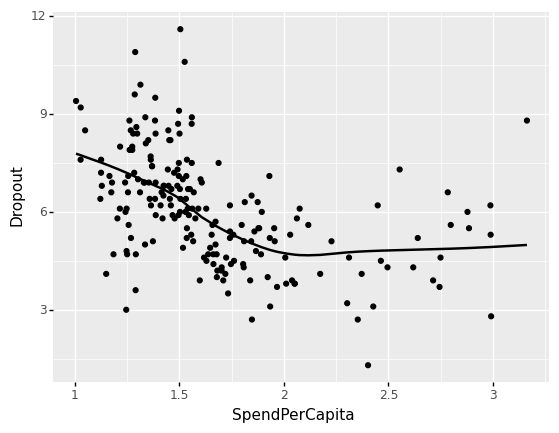

<ggplot: (8773360823200)>

In [60]:
ggplot(keyYears, aes(x = 'SpendPerCapita', y = 'Dropout')) + geom_point(stat = 'identity') + stat_smooth()

When examining for a linear relationship between the amount a state spends per capita and their dropout rate a pattern is not readily apparent so we will need to examine other visualizations.

/Users/shayleedavis/opt/anaconda3/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


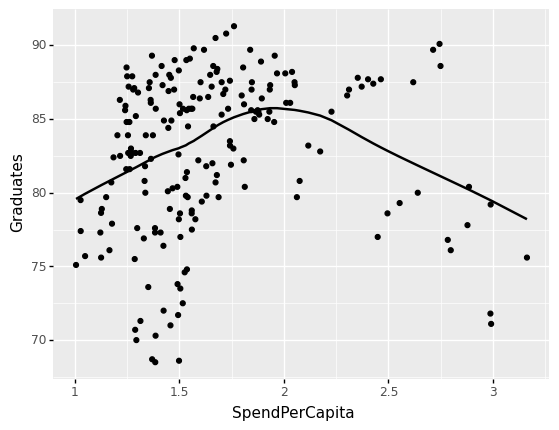

<ggplot: (8773361060479)>

In [61]:
ggplot(keyYears, aes(x = 'SpendPerCapita', y = 'Graduates')) + geom_point(stat = 'identity') + stat_smooth()


We cannot easily see a linear correlation between the spend per capita and the graduation/dropout rates. Which means the amount spent might be too skewed by other factors such as cost of living.

/Users/shayleedavis/opt/anaconda3/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


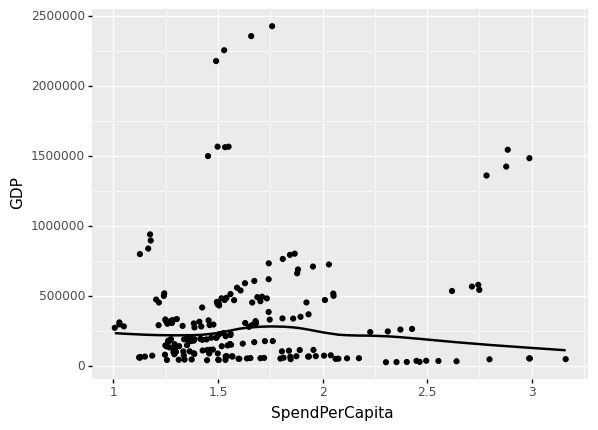

<ggplot: (8773361109116)>

In [62]:
ggplot(keyYears, aes(x = 'SpendPerCapita', y = 'GDP')) + geom_point(stat = 'identity') + stat_smooth()

In some areas you can see a rise in the state's GDP results in a raise of how much they spend per capita. But in the majority of data points we are seeing we don't get a nice 1-1 linear relationship.

In [63]:
stateMeltedMedian = pd.DataFrame(keyYears.groupby('State')['MedInc'].mean().reset_index())
stateMeltedDropout = pd.DataFrame(keyYears.groupby('State')['Dropout'].mean().reset_index())

In [64]:
stateMeltedMedian.sort_values('MedInc', ascending = False).head(10)

,State,MedInc
28,New Hampshire,73607.75
19,Maryland,73218.00
1,Alaska,72734.00
6,Connecticut,72066.00
10,Hawaii,68026.25
22,Minnesota,67629.00
5,Colorado,66503.50
29,New Jersey,66455.50
20,Massachusetts,66451.75
46,Washington,65135.75


In [65]:
stateMeltedDropout.sort_values('Dropout', ascending = True).head(10)

,State,Dropout
44,Vermont,2.925
28,New Hampshire,3.825
20,Massachusetts,3.850
45,Virginia,4.000
10,Hawaii,4.075
29,New Jersey,4.125
6,Connecticut,4.225
18,Maine,4.250
22,Minnesota,4.300
26,Nebraska,4.525


We can see an overlap where 6 of the states within the top 10 states for Median Income have one of the ten lowest dropout rates. (New Hampshire, Connecticut, Hawaii, Minnesota, New Jersey, and Massachusetts)

In [66]:
stateMeltedMedian.sort_values('MedInc', ascending = False).tail(10)

,State,MedInc
35,Oklahoma,47845.25
39,South Carolina,47297.00
41,Tennessee,46437.75
0,Alabama,45332.00
30,New Mexico,45105.50
17,Louisiana,44237.25
16,Kentucky,43855.25
3,Arkansas,43250.75
47,West Virginia,42449.75
23,Mississippi,37248.75


In [67]:
stateMeltedDropout.sort_values('Dropout', ascending = False).head(10)

,State,Dropout
17,Louisiana,9.950
27,Nevada,9.400
30,New Mexico,8.800
2,Arizona,8.675
35,Oklahoma,8.275
23,Mississippi,7.775
0,Alabama,7.725
13,Indiana,7.650
9,Georgia,7.525
42,Texas,7.375


And below we will visualize the linear relationship between the median income and dropout rates.

/Users/shayleedavis/opt/anaconda3/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


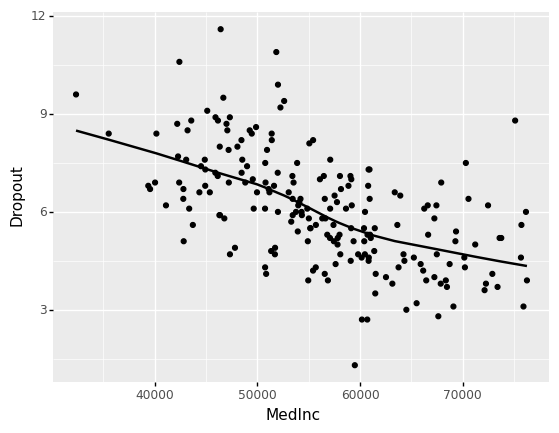

<ggplot: (8773359713178)>

In [68]:
ggplot(keyYears, aes(x = 'MedInc', y = 'Dropout')) + geom_point(stat = 'identity') + stat_smooth()

/Users/shayleedavis/opt/anaconda3/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


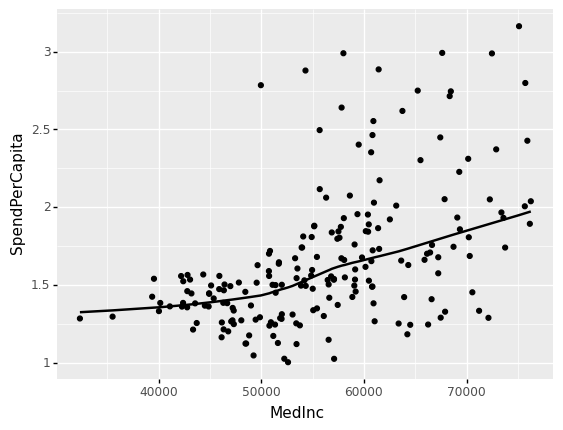

<ggplot: (8773361016586)>

In [69]:
ggplot(keyYears, aes(x = 'MedInc', y = 'SpendPerCapita')) + geom_point(stat = 'identity') + stat_smooth()

Although spend per capita did not immediately show a linear relationship with the dropout/graduate rates. You can see the Median income does influence dropout rates and it also influences how much a state spends per student.

/Users/shayleedavis/opt/anaconda3/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


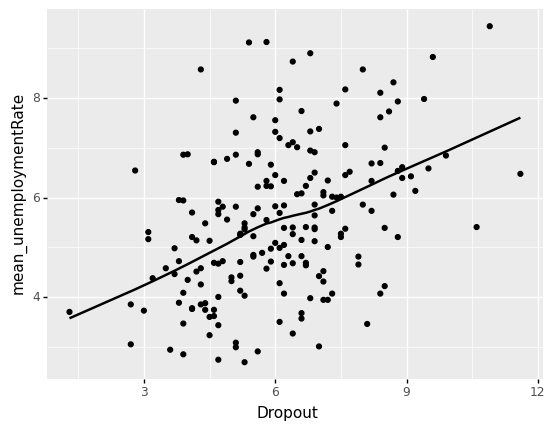

<ggplot: (8773361036490)>

In [70]:
ggplot(keyYears, aes(x= 'Dropout', y = 'mean_unemploymentRate',)) + geom_point(stat = 'identity') + stat_smooth()

## Question for meeting tonight
Is there a way to do the division within the ggplot? ANSWER: CREATE COLUMN.
And make Graph below useful?

In [71]:
#MAKE COLUMN!

#ggplot(keyYears, aes(x= 'Dropout', y = ('tax_all'/'Population'))) + geom_point(stat = 'identity') + stat_smooth()

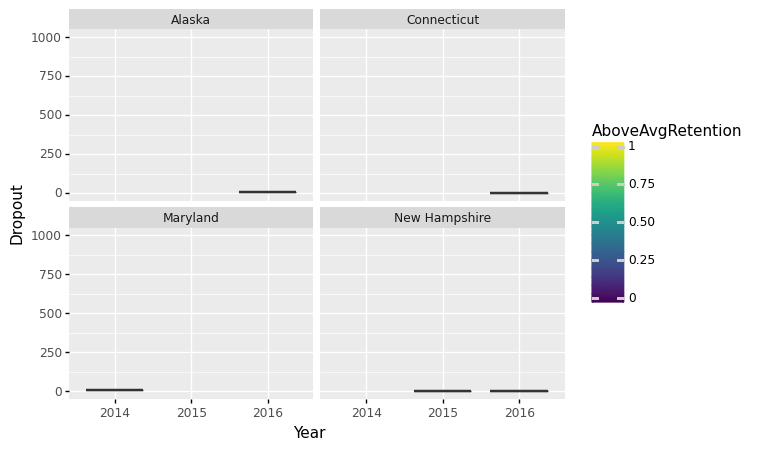

<ggplot: (8773361097780)>

In [87]:
ggplot(keyYears.sort_values('MedInc', ascending = False).head(), aes(x = 'Year', y = 'Dropout', fill = 'AboveAvgRetention')) + geom_boxplot() + scale_y_continuous(limits = (0,1000)) + facet_wrap('State')

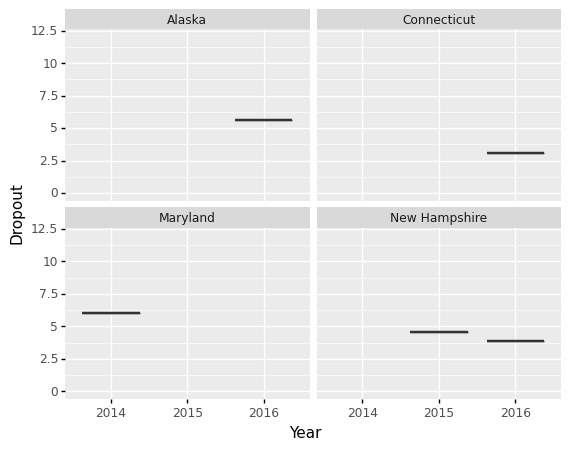

<ggplot: (8773361265415)>

In [91]:
#USE keyYears ['state == ']

ggplot((keyYears.sort_values('MedInc', ascending = False).head()), aes(x = 'Year', y = 'Dropout')) + geom_boxplot() + scale_y_continuous(limits = (0,12)) + facet_wrap('State')

In [73]:
StateMonetary = pd.DataFrame(keyYears.groupby('State')['MedInc','Dropout','Graduates','SpendPerCapita','GDP'].mean().reset_index())

<ipython-input-73-0e96f53e4478>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [74]:
StateMonetarySorted = StateMonetary.sort_values('Dropout', ascending = True).reset_index()

In [76]:
keyYears['Year'] = keyYears['Year'].astype('category')

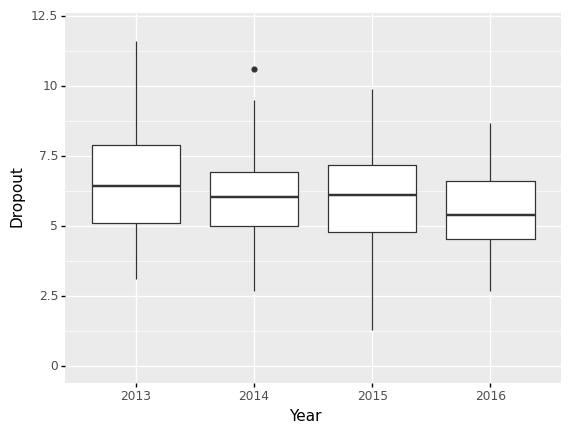

<ggplot: (8773361937893)>

In [77]:
ggplot(keyYears, aes(x = 'Year', y = 'Dropout')) + geom_boxplot() + scale_y_continuous(limits = (0,12))

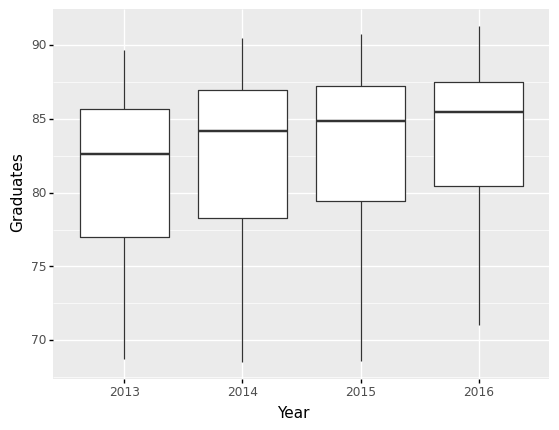

<ggplot: (8773359580218)>

In [78]:
ggplot(keyYears, aes(x = 'Year', y = 'Graduates')) + geom_boxplot() + scale_y_continuous() 

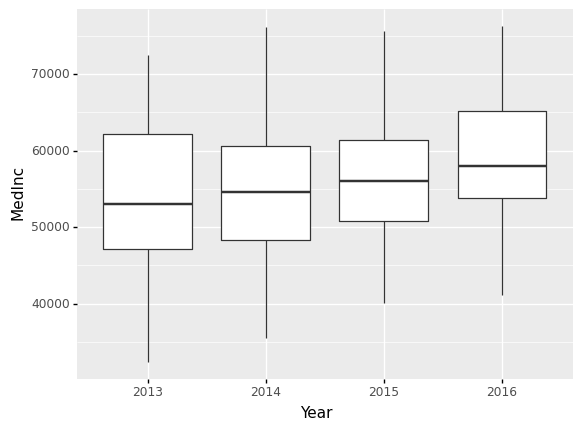

<ggplot: (8773360834326)>

In [79]:
ggplot(keyYears, aes(x = 'Year', y = 'MedInc')) + geom_boxplot() + scale_y_continuous() 

### Observations from yearly boxplots

The median income seems to show a similar inverse relationship to the yearly dropout rate. It also shows a rising pattern in graduation rates. As median income rises, the dropout rate seems to fall.

In [80]:
ts_agg = keyYears.groupby(['Year'])['State', 'Graduates', 'Dropout', 'MedInc', 'GDP', 'SpendPerCapita'].mean().reset_index().melt(id_vars = ['Year'], var_name = 'cum_type', value_name = 'cum')
print(ts_agg)

    Year        cum_type            cum
0   2013       Graduates      81.416667
1   2014       Graduates      82.458000
2   2015       Graduates      83.280000
3   2016       Graduates      84.012000
4   2013         Dropout       6.596000
5   2014         Dropout       6.086000
6   2015         Dropout       6.092000
7   2016         Dropout       5.598000
8   2013          MedInc   54200.720000
9   2014          MedInc   54962.540000
10  2015          MedInc   56750.140000
11  2016          MedInc   58942.940000
12  2013             GDP  329484.706500
13  2014             GDP  343014.924000
14  2015             GDP  355986.020500
15  2016             GDP  365185.340000
16  2013  SpendPerCapita       1.612556
17  2014  SpendPerCapita       1.649869
18  2015  SpendPerCapita       1.687988
19  2016  SpendPerCapita       1.702964


<ipython-input-80-1726b2fedbce>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


Through our 4 year window we can see at a national level that the GDP, state spending per capita, median income, and graduation rates are rising each year while the dropout rate does the inverse. Which are all favorable outcomes.

### Question for Tonight
Is there a way to  aggregate these values in the code of the graph? #ADD COLUMNS
Also is there a way to make the below graph attractive and useful? Right now how I have it set it's not very helpful. Maybe get rid of the coloring? Is ther any coloring that makes it useful?

In [ ]:
# Add a comparision of the top 5 and bottom 5 with high/low ranges of unemployment.

In [81]:
keyYears['unemploymentRange'] = keyYears['max_unemploymentRate'] - keyYears['min_unemploymentRate']

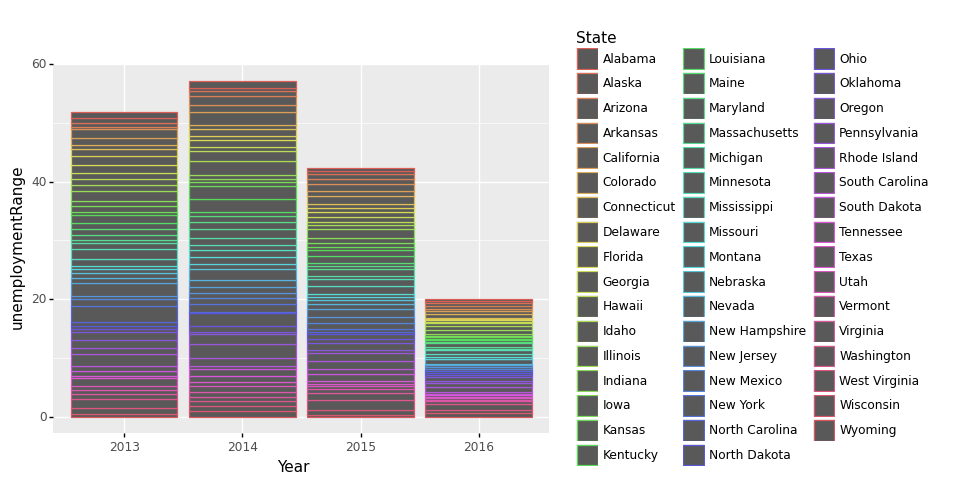

<ggplot: (8773361956112)>

In [82]:
ggplot(keyYears, aes(x ='Year', y = 'unemploymentRange', color = 'State')) + geom_bar(stat = 'identity')

In [83]:
#Let's remove the averages before we check out all the correlation coefficents.
df = keyYears.iloc[:, 2:13]

<AxesSubplot:>

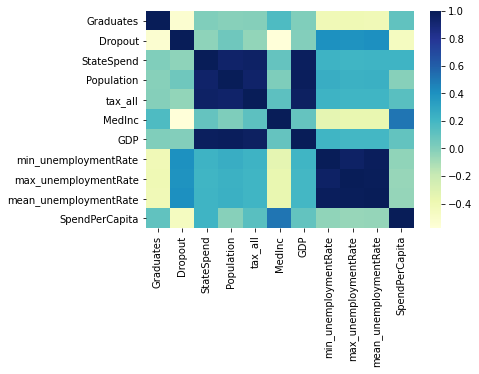

In [84]:
sns.heatmap(df.corr(), cmap="YlGnBu")

We already experimented and saw some of the correlation between median income and dropout rates. This heat map also shows us the closer relationship between unemployment and dropout rates.

In [85]:
abc = pd.DataFrame(keyYears.groupby(['State', 'Year'])['Dropout'].mean().reset_index())
abc.loc[abc['Year'] == 2016].sort_values('Dropout').head(10)

,State,Year,Dropout
135,North Dakota,2016,2.7
27,Connecticut,2016,3.1
43,Hawaii,2016,3.6
119,New Jersey,2016,3.7
83,Massachusetts,2016,3.8
115,New Hampshire,2016,3.9
183,Virginia,2016,3.9
75,Maine,2016,4.1
47,Idaho,2016,4.1
155,Rhode Island,2016,4.1


In [86]:
abc.loc[abc['Year'] == 2016].sort_values('Dropout').tail(10)

,State,Year,Dropout
3,Alabama,2016,6.9
55,Indiana,2016,7.0
31,Delaware,2016,7.1
15,Arkansas,2016,7.2
187,Washington,2016,7.5
11,Arizona,2016,7.6
143,Oklahoma,2016,7.9
123,New Mexico,2016,8.2
111,Nevada,2016,8.2
71,Louisiana,2016,8.7


## Question for tonight

How to make above coding more concise. How to code for the differences between the years concisely. My only idea is to make a data frame for 2016 and then 2013 and then find their differences. Which leads to issues with state name and too clunky of coding. I didn't do the above averages since it'd be about 25 states. Should I still do it?

### Summary of our Exploratory Data Analysis 
We notice that Vermont, New Hampshire, Massachusetts, Virginia, Hawaii, New Jersey, Connecticut, Maine, Minnesota, and Nebraska have the lowest dropout rates  on average in the past 4 years. 
In 2016 itself we notice the lowest dropout rates come from North Dakota, Connecticut, Hawaii, New Jersey, Massachusetts, New Hampshire, Virginia, Maine, Idaho, and Rhode Island (a 7/10 overlap with the average).

We notice that Louisiana, Nevada, New Mexico, Arizona, Oklahoma, Mississippi, Alabama, Indiana, Georgia, and Texas have the highest dropout rates  on average in the past 4 years.
I 2016 itself we notice the highest dropout rates come from Alabama, Indiana, Delaware, Arkansas, Washington, Arizona, Oklahoma, New Mexico, Nevada, and Louisiana (a 7/10 overlap with the average).

We also notice that while the GDP and state spending per student have a linear relationship to the state median income they don't have a linear correlation to dropoutrates. Even while we can see a linear relationship between median income and drop out rates. Which leads us towards conclusions that other studies have proven such as students with parents who have gone to college are more likely to go to college. 

### Questions left to answer
What are the states that drop out rates that are above the US avg (overall vs recent years - like above)
What are the states that have seen a dramatic increase/decrease in drop out rates? (calculation: look at 2013’s drop out rates for each state vs late year available drop out rates. Calculate the difference and rank order to get top/bottom states)


In [95]:
temp1 = keyYears[['State', 'Year', 'Dropout']]
temp1.tail()

,State,Year,Dropout
195,Virginia,2016,3.9
196,Washington,2016,7.5
197,West Virginia,2016,6.6
198,Wisconsin,2016,4.7
199,Wyoming,2016,5.2


In [96]:
temp2 = temp1.loc[temp1['Year'].isin([2013, 2016]),:]

In [103]:
pd.pivot_table(temp2, index = 'State', columns = 'Year')

MultiIndex([('Dropout', 2013),
            ('Dropout', 2016)],
           names=[None, 'Year'])

In [108]:
temp3 = pd.pivot_table(temp2, index = 'State', columns = 'Year')

In [109]:
temp3.columns = temp3.columns.droplevel()

In [110]:
temp3.head()

Year,2013,2016
State,,
Alabama,8.9,6.9
Alaska,6.2,5.6
Arizona,9.4,7.6
Arkansas,6.8,7.2
California,6.8,5.3


In [111]:
temp3['Diff'] = temp3[2013] - temp3[2016]

TypeError: cannot insert an item into a CategoricalIndex that is not already an existing category

# 4) Preprocess and Train Data